In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
import seaborn as sns
from skimage.feature import graycomatrix, graycoprops

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  confusion_matrix


import concurrent.futures

## Preprocessing 

In [2]:
def color_treatment(img, plot=False):
    """
    Takes RGB or RGBA image then transforms then to grayscale, thresholds it, and inverts colors if needed.
    Uses opencv.
    Inputs:
        img -> ndarray : the image to be processed. Can be RGB or RGBA. Needs to be read by opencv.
        plot -> boolean : optional flag to plot image after fixing colors.
    Output:
        ndarray holding the resulted image.
    """
    # convert to grayscale
    gray = img
    if len(img.shape) >= 3:  # handle if image is RGB or RGBA
        rgb_img = img[:, :, :3]  # to ignore the A channel if it's RGBA
        gray = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    
    # median filter to reduce salt and pepper in extreme cases
    median = cv2.medianBlur(gray, 3)
    

    # gaussian blur and otsu threshold to treat salt and pepper and binarize the image
    gaussian = cv2.GaussianBlur(median, (5, 5), 0)
    thresholded = cv2.threshold(
        gaussian, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # now the image is grayscale we need to standardize the text color using the 4 corners (to avoid if one has salt and pepper)
    standard = thresholded
    right = thresholded.shape[0]-1
    bottom = thresholded.shape[1]-1
    if (int(thresholded[0, 0]) + int(thresholded[right, bottom]) + int(thresholded[0, bottom]) + int(thresholded[right, 0])) / 4 >= 127:  # 2 corners are white
        # int is used to avoid overflow in addition (max value is 255)
        standard = cv2.bitwise_not(thresholded)

    if plot:
        plt.imshow(standard , cmap="gray")
        plt.show()

    return standard

In [3]:
def get_text_points(image, pad=True, threshold=15, plot=False):
    """
    Takes a binary image to select only the points representing the text and ignore small contours are may be noise.
    Uses opencv.
    Inputs:
        image -> ndarray : a binary image containing text with noise.
        pad -> boolean : optional parameter to extend the boundaries of the image or not.
        threshold -> integer : optional parameter that can change the threshold of the number of points in a contour to be removed.
        plot -> boolean : optional flag to plot image with bounding rectangles for contours.
    Output:
        points-> ndarray : contains all the points that represent text.
        textContours -> ndarray : array of contours that contain text only.
        padded_image -> ndarray : a padded version of the image if pad is set to true.
    """
    padded_image = np.copy(image)
    if pad:
        padded_image = np.zeros((image.shape[0]*2, image.shape[1]*2), np.uint8)
        padded_image[image.shape[0]//2:image.shape[0]*3//2,
                     image.shape[1]//2:image.shape[1]*3//2] = image

    contours, _ = cv2.findContours(
        padded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    textContours = [cnt for cnt in contours if len(cnt) >= threshold]

    points = []

    for contour in textContours:
        x, y, w, h = cv2.boundingRect(contour)
        points.append([x, y])
        points.append([x+w, y+h])

    if plot:
        text_contours_plot = np.copy(padded_image)

        for contour in textContours:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(text_contours_plot, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)

        plt.figure(figsize=(12, 10))
        plt.imshow(text_contours_plot, cmap='gray')

    return np.array(points), textContours, padded_image

In [4]:
def tri_angle_area(points, image=None, plot=False, verbose=False, vertices=False):
    """
    Takes points bounding the text to find the triangle that fits these points and calculate its area and the angle at which the text is rotated.
    Uses opencv.
    Inputs:
        points-> ndarray : points that surround the text.
        image -> ndarray : optional parameter that has the image (used for plotting).
        plot -> boolean : optional flag to plot the enclosing triangle. (needs the image parameter).
        verbose -> boolean : optional flag to show info about the resulting triangle.
        vertices -> boolean : optional flag to output the triangle vertices.
    Output:
        angle -> float : angle at which the text is rotated.
        area -> float : area of the triangle.
        vert -> list : optional output that holds the triangle vertices.

    """
    triangle = cv2.minEnclosingTriangle(points)
    x = [triangle[1][0][0][0], triangle[1][1][0][0], triangle[1][2][0][0]]
    y = [triangle[1][0][0][1], triangle[1][1][0][1], triangle[1][2][0][1]]
    lengths = []

    angle = 0
    for i in range(3):
        dx = x[i] - x[(i+1) % 3]
        dy = y[i] - y[(i+1) % 3]

        lengths.append(np.sqrt(dx**2 + dy**2))

        # TODO: if it's not a right angle triangle
        if abs(dx) >= 50 and abs(dy) >= 50:
            angle = dy/dx

    angle = np.degrees(np.arctan(angle))

    if abs(angle) > 80 or abs(angle) < 5:
        angle = 0

    s = np.sum(lengths) / 2
    # Calculate area using Heron's formula
    area = np.sqrt(s * (s - lengths[0]) * (s - lengths[1]) * (s - lengths[2]))

    if plot:
        plt.imshow(image, cmap ="gray")
        plt.plot(x, y, color='green', linewidth=2)
        # plt.axis('off')
        plt.show()
    
    if verbose:
        print("triangle area:", area)
        print("triangle angle:", angle)
        print("triangle sides:", lengths)

    if vertices:
        return angle, area, [ [x[0], y[0]], [x[1], y[1]], [x[2], y[2]]]
    return angle, area

In [5]:
def rect_angle_area(points, image=None, plot=False, verbose=False, vertices=False):
    """
    Takes points bounding the text to find the rectangle that fits these points and calculate its area and the angle at which the text is rotated.
    Uses opencv.
    Inputs:
        points-> ndarray : points that surround the text.
        image -> ndarray : optional parameter that has the image (used for plotting).
        plot -> boolean : optional flag to plot the enclosing rectangle. (needs the image parameter).
        verbose -> boolean : optional flag to show info about the resulting rectangle.
        vertices -> boolean : optional flag to output the rectangle vertices.
    Output:
        angle -> float : angle at which the text is rotated.
        area -> float : area of the rectangle.
        box -> list : optional output that holds the rectangle vertices.
    """
    rect = cv2.minAreaRect(points)
    angle = rect[-1]

    if abs(angle) > 80 or abs(angle) < 5:
        angle = 0

    box = cv2.boxPoints(rect)

    # TODO: handle when it's 90 degrees already

    sorted_indices = np.argsort(box[:, 1])  # Sort based on y
    vert = box[sorted_indices]
    
    w = np.sqrt((vert[0,0] - vert[1,0]) **2 + (vert[0,1] - vert[1,1]) **2)
    h = np.sqrt((vert[0,0] - vert[2,0]) **2 + (vert[0,1] - vert[2,1]) **2)

    area = w * h

    if plot:
        plt.imshow(image, cmap='gray')
        plt.plot(box[:, 0], box[:, 1], color='green', linewidth=2)
        # plt.axis('off')
        plt.show()

    if verbose:
        print("rectangle area:", area)
        print("rectangle angle:", angle)
        print("rectangle vertices:", box)
        print("rectangle w, h:", w,h)
    
    if vertices:
        return angle, area, box

    return angle, area

In [6]:
def skew_treatment(image, plot=False, verbose=False):
    """
    Takes a binary image to find the angle needed to fix the skew of the image.
    Uses opencv.
    Inputs:
        image -> ndarray : The image to be processed. Needs to be a binary image. Needs to be read by opencv.
        plot -> boolean : optional flag to plot the original & the rotated image.
        verbose -> boolean : optional flag to show info about the rotation process.
    Output:
        rotated -> ndarray : holding the rotated image.
    """
    points, _, padded = get_text_points(image)

    rect_angle, rect_area = rect_angle_area(points, verbose=verbose)
    tri_angle, tri_area = tri_angle_area(points, verbose=verbose)

    # TODO: condition isn't working right

    (h, w) = padded.shape[:2]
    center = np.mean(points, axis=0)

    angle = rect_angle
    if rect_area > tri_area:
        angle= tri_angle

    M = cv2.getRotationMatrix2D(center, -angle, 1.0)
    rotated = cv2.warpAffine(padded, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    rotated = rotated[ rotated.shape[0]//4: rotated.shape[0]*3//4,
                      rotated.shape[0]//4: rotated.shape[1]*3//4]

    if plot:
        plt.imshow(padded)
        plt.title("Padded")
        plt.show()
        plt.imshow(rotated)
        plt.title("Rotated")
        plt.show()

    if verbose:
        if rect_area > tri_area:
            print("used triangle angle")
        else:
            print("used rectangle angle")

    return rotated

In [7]:
def preprocess(image):
    return (color_treatment(image))

## Preparation

#### Read images

In [8]:

def read_images_with_labels(folder_path):
    data = []
    
    class_names = os.listdir(folder_path)
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                if filename.endswith('.jpeg'):
                    img_path = os.path.join(class_path, filename)
                    # Read and preprocess the image
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        # Append image and label to the data list
                        data.append([img, class_name])
    
    return data

In [9]:
folder_path = './fonts-dataset'
images = read_images_with_labels(folder_path)

#### Extract features 

In [10]:
def extract_texture_features(img_resized):    
    img_resized_co_matrix = graycomatrix(img_resized, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    return [graycoprops(img_resized_co_matrix, prop).ravel()[0] for prop in
                                                ['correlation','contrast','energy','homogeneity']]

def extract_coeffs_features(img):    
    img_co_matrix = graycomatrix(( ((img - img.min()) / (img.max() - img.min())) * (255) ).astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    return  [graycoprops(img_co_matrix, prop).ravel()[0] for prop in
                        ['correlation']]
    
def apply_wavelet_transform(img):
    return pywt.wavedec2(img, 'Coif3', level=3)

In [11]:
def extract_features_from_coefficients(coeffs):
    features = {}
    
    # Extract features from approximation coefficients
    feat = extract_coeffs_features(coeffs[0])
        
    features['approximation_std'] = np.std(coeffs[0])
    features['approximation_correlation']= feat[0]

    
    # Extract features from detail coefficients
    for level, detail_coeffs in enumerate(coeffs[1:], start=1):
        for i, detail_coef in enumerate(detail_coeffs):
            features[f'level{level}_detail{i+1}_std'] = np.std(detail_coef)
            
            # Calculate GLCM features for detail coefficients
            feat = extract_coeffs_features(detail_coef)
            
            features[f'level{level}_detail{i+1}_correlation'] = feat[0]

    
    return features

In [12]:
def process_image(img_label_pair):
    img, label = img_label_pair
    img = preprocess(img)
    img_resized = cv2.resize(img, (900, 900))
    texture_features = extract_texture_features(img_resized)
    data = {
        'texture_std': np.std(img_resized),
        'texture_correlation': texture_features[0],
        'texture_contrast': texture_features[1],
        'texture_energy': texture_features[2],
        'texture_homogeneity': texture_features[3],
    }
    coeffs = apply_wavelet_transform(img_resized)
    features = extract_features_from_coefficients(coeffs)
    for key, value in features.items():
        data[key] = value
    data['class'] = label
    return data

In [13]:
def Wrangle(images):

    data = {
        'approximation_std': [],
        'approximation_correlation': [],
        'level1_detail1_std': [],
        'level1_detail1_correlation': [],
        'level1_detail2_std': [],
        'level1_detail2_correlation': [],
        'level1_detail3_std': [],
        'level1_detail3_correlation': [],
        'level2_detail1_std': [],
        'level2_detail1_correlation': [],
        'level2_detail2_std': [],
        'level2_detail2_correlation': [],
        'level2_detail3_std': [],
        'level2_detail3_correlation': [],
        'level3_detail1_std': [],
        'level3_detail1_correlation': [],
        'level3_detail2_std': [],
        'level3_detail2_correlation': [],
        'level3_detail3_std': [],
        'texture_std': [], 'texture_homogeneity': [], 'texture_contrast': [], 'texture_energy': [], 'texture_correlation': [], 'class': []
    }
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(process_image, images))

    for result in results:
        for key, value in result.items():
            if key == "level3_detail3_correlation":
                continue
            data[key].append(value)
    
    df = pd.DataFrame(data)
    return df

In [14]:
df = Wrangle(images = images)
df

C:\Users\20112\AppData\Local\Temp\ipykernel_12716\2574374128.py:7: RuntimeWarning: invalid value encountered in divide
  img_co_matrix = graycomatrix(( ((img - img.min()) / (img.max() - img.min())) * (255) ).astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
C:\Users\20112\AppData\Local\Temp\ipykernel_12716\2574374128.py:7: RuntimeWarning: invalid value encountered in cast
  img_co_matrix = graycomatrix(( ((img - img.min()) / (img.max() - img.min())) * (255) ).astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)


,approximation_std,approximation_correlation,level1_detail1_std,level1_detail1_correlation,level1_detail2_std,level1_detail2_correlation,level1_detail3_std,level1_detail3_correlation,level2_detail1_std,level2_detail1_correlation,...,level3_detail1_correlation,level3_detail2_std,level3_detail2_correlation,level3_detail3_std,texture_std,texture_homogeneity,texture_contrast,texture_energy,texture_correlation,class
0,116.111558,0.761494,47.800748,0.437655,42.312648,-0.131788,30.268070,-0.093948,26.434171,0.314142,...,0.327266,7.831857,-0.340882,4.285803,22.740606,0.991181,160.830216,0.986212,0.844670,IBM Plex Sans Arabic
1,337.044378,0.560603,181.750538,0.403116,187.189927,-0.319300,85.664700,-0.312825,53.872991,0.499114,...,0.375913,20.014184,-0.231357,9.727407,66.524155,0.947137,1048.031020,0.891261,0.881710,IBM Plex Sans Arabic
2,366.651304,0.558130,206.999619,0.327745,210.722530,-0.105500,115.607238,-0.317442,79.798182,0.475241,...,0.323909,24.608630,-0.170577,13.083519,76.774513,0.912098,1708.542993,0.840974,0.855208,IBM Plex Sans Arabic
3,338.842889,0.744407,136.883715,0.374039,131.310090,-0.140273,90.064962,-0.116094,74.552459,0.354346,...,0.307632,24.504563,-0.370023,12.634272,66.021303,0.920462,1479.977066,0.875181,0.830401,IBM Plex Sans Arabic
4,490.973497,0.548326,188.944681,0.438902,196.548427,-0.603217,66.351341,-0.408213,48.054984,0.313365,...,0.410043,20.478791,-0.340518,9.787733,82.252197,0.948499,1016.707737,0.850985,0.924931,IBM Plex Sans Arabic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,343.907937,0.550453,145.199148,0.380876,140.459755,-0.395839,67.370526,-0.311989,41.900049,0.251755,...,0.225602,15.212406,-0.321128,9.111548,60.423799,0.963717,657.601486,0.916868,0.910036,Scheherazade New
3996,169.454137,0.437195,72.905880,-0.024890,74.761517,-0.430977,67.567499,-0.272227,32.860484,0.161945,...,0.107594,8.845729,-0.353288,6.972105,33.060206,0.983410,278.650787,0.972253,0.872665,Scheherazade New
3997,301.157569,0.462978,154.263138,0.343419,153.467133,-0.353772,81.964198,-0.259219,49.589399,0.312715,...,0.239321,18.669739,-0.304382,10.276112,59.257079,0.950607,944.808587,0.910935,0.865604,Scheherazade New
3998,235.502534,0.520829,126.699558,0.353624,97.549938,-0.280858,60.750443,-0.316034,39.369035,0.358736,...,0.250836,12.889277,-0.319846,7.655692,45.118312,0.974501,464.994908,0.950781,0.885910,Scheherazade New


## Test model

In [15]:
X = df.drop(columns=['class'])
y= df['class']

In [16]:
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=42,train_size=0.8)

In [17]:
pca = PCA(n_components=24)
scaler = MinMaxScaler()
model = make_pipeline(scaler,pca,RandomForestClassifier(random_state=42,n_estimators=835))#515 give close result #765 give the best result  and distribution 


In [18]:
model.fit(x_train,y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('pca', PCA(n_components=24)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=835, random_state=42))])

In [19]:
model.score(x_test,y_test)*100

96.5

In [20]:
cv_acc_scores = cross_val_score(model,X,y,cv=5,n_jobs=-1)
cv_acc_scores*100

array([97.125, 96.   , 97.875, 96.5  , 97.5  ])

In [21]:
np.mean(cv_acc_scores*100)
#joblib file

97.0

## Model insights 

In [22]:
y_pred =model.predict(X)

In [23]:
misclassified_indices=np.where(y_pred != y)[0]
misclassified_indices

array([ 257,  354,  408,  655,  888, 1104, 1171, 1498, 1539, 1745, 1945,
       2334, 2428, 2618, 2643, 2664, 3055, 3107, 3182, 3200, 3265, 3278,
       3322, 3440, 3614, 3693, 3778, 3991], dtype=int64)

In [24]:
y_pred[misclassified_indices]

array(['Marhey', 'Marhey', 'Marhey', 'Marhey', 'Scheherazade New',
       'IBM Plex Sans Arabic', 'IBM Plex Sans Arabic',
       'IBM Plex Sans Arabic', 'IBM Plex Sans Arabic',
       'IBM Plex Sans Arabic', 'IBM Plex Sans Arabic', 'Scheherazade New',
       'IBM Plex Sans Arabic', 'IBM Plex Sans Arabic',
       'IBM Plex Sans Arabic', 'IBM Plex Sans Arabic', 'Marhey', 'Marhey',
       'Marhey', 'Marhey', 'Marhey', 'Marhey', 'IBM Plex Sans Arabic',
       'Marhey', 'Marhey', 'Marhey', 'Marhey', 'Marhey'], dtype=object)

In [25]:
y[misclassified_indices]

257     IBM Plex Sans Arabic
354     IBM Plex Sans Arabic
408     IBM Plex Sans Arabic
655     IBM Plex Sans Arabic
888     IBM Plex Sans Arabic
1104                Lemonada
1171                Lemonada
1498                Lemonada
1539                Lemonada
1745                Lemonada
1945                Lemonada
2334                  Marhey
2428                  Marhey
2618                  Marhey
2643                  Marhey
2664                  Marhey
3055        Scheherazade New
3107        Scheherazade New
3182        Scheherazade New
3200        Scheherazade New
3265        Scheherazade New
3278        Scheherazade New
3322        Scheherazade New
3440        Scheherazade New
3614        Scheherazade New
3693        Scheherazade New
3778        Scheherazade New
3991        Scheherazade New
Name: class, dtype: object

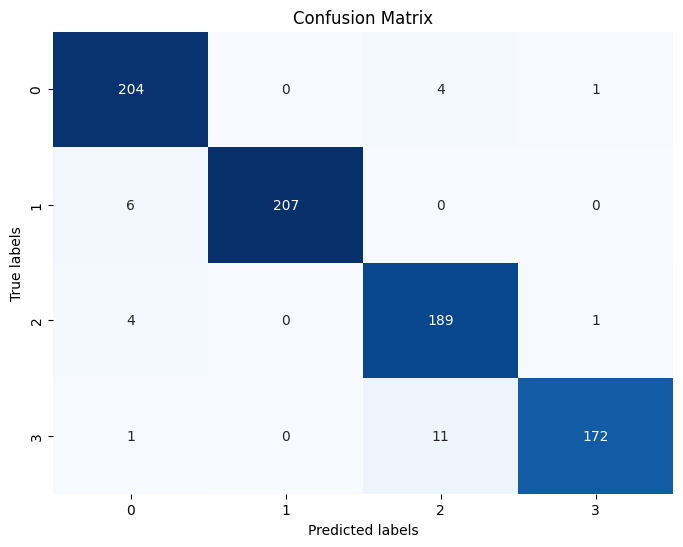

In [26]:
conf_matrix = confusion_matrix(y_test, model.predict(x_test))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

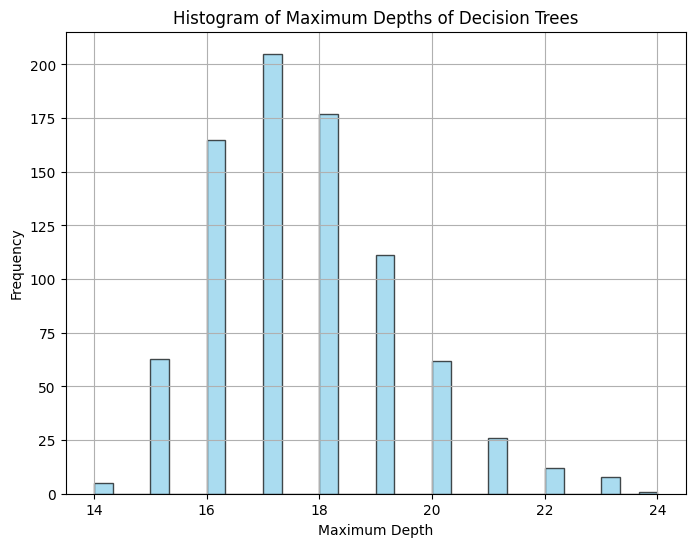

In [49]:

max_depths = [tree.tree_.max_depth for tree in model.named_steps['randomforestclassifier'].estimators_]
# Get the max_depth parameter
plt.figure(figsize=(8, 6))
plt.hist(max_depths, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Maximum Depth')
plt.ylabel('Frequency')
plt.title('Histogram of Maximum Depths of Decision Trees')
plt.grid(True)
plt.show()

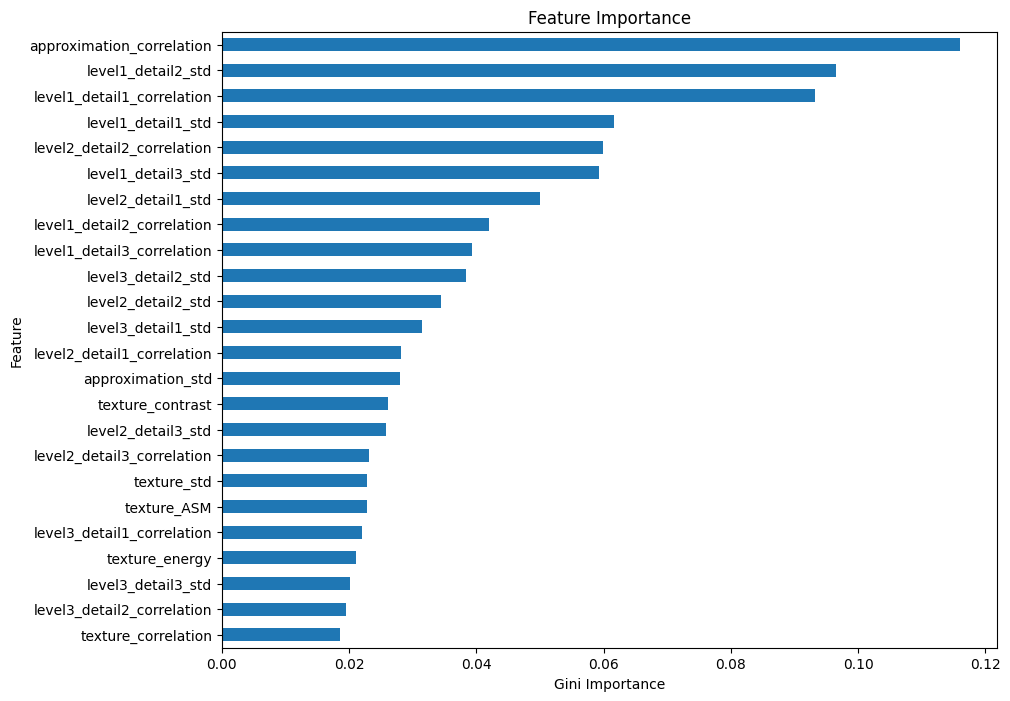

In [60]:
features = X.columns
# Extract importances from model
importances = model.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp =pd.Series(importances,index=features)
# Plot 10 most important features
plt.figure(figsize=(10, 8))

feat_imp.sort_values().head(50).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");


## Model hyperParameters toning  

In [29]:
params = {

    "randomforestclassifier__n_estimators":range(100,1000,5),
    "pca__n_components":range(X.columns.shape[0]-4,X.columns.shape[0]+1,1)

}
grid_model = GridSearchCV(
    model,
    param_grid=params,
    cv=5, # numbre of folds  in cross validation
    n_jobs=-1,
    verbose=1,
)

In [30]:
grid_model.fit(X,y)

Fitting 5 folds for each of 900 candidates, totalling 4500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('pca', PCA(n_components=24)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_estimators=765,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'pca__n_components': range(20, 25),
                         'randomforestclassifier__n_estimators': range(100, 1000, 5)},
             verbose=1)

In [31]:

cv_results = pd.DataFrame(grid_model.cv_results_).set_index("rank_test_score")
cv_results.sort_index().head(30)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_pca__n_components,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,
1,20.408001,0.217541,0.324598,0.012910,24,835,"{'pca__n_components': 24, 'randomforestclassif...",0.97125,0.96000,0.97875,0.96500,0.97500,0.97000,0.006755
2,19.567798,0.049244,0.297201,0.006399,24,805,"{'pca__n_components': 24, 'randomforestclassif...",0.97000,0.95875,0.97875,0.96500,0.97625,0.96975,0.007306
2,19.857597,0.268061,0.316601,0.017806,24,810,"{'pca__n_components': 24, 'randomforestclassif...",0.97000,0.95875,0.97875,0.96500,0.97625,0.96975,0.007306
2,20.180001,0.456044,0.308399,0.024278,24,815,"{'pca__n_components': 24, 'randomforestclassif...",0.97000,0.95875,0.97875,0.96500,0.97625,0.96975,0.007306
2,18.068398,0.180797,0.271003,0.003286,24,735,"{'pca__n_components': 24, 'randomforestclassif...",0.97000,0.95875,0.97875,0.96500,0.97625,0.96975,0.007306
2,20.782798,0.252409,0.319201,0.021831,24,840,"{'pca__n_components': 24, 'randomforestclassif...",0.97125,0.95875,0.97875,0.96500,0.97500,0.96975,0.007133
2,18.822399,0.351424,0.288400,0.020401,24,745,"{'pca__n_components': 24, 'randomforestclassif...",0.97000,0.95875,0.97875,0.96500,0.97625,0.96975,0.007306
8,18.996199,0.237156,0.287200,0.007277,24,770,"{'pca__n_components': 24, 'randomforestclassif...",0.97000,0.96000,0.98000,0.96500,0.97250,0.96950,0.006782
8,18.573399,0.121541,0.276000,0.010334,24,765,"{'pca__n_components': 24, 'randomforestclassif...",0.97000,0.96125,0.98000,0.96375,0.97250,0.96950,0.006643


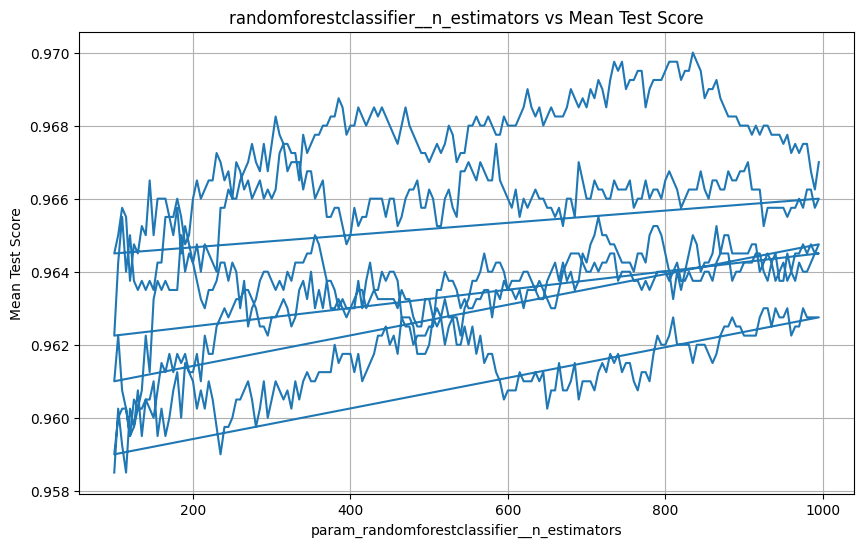

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(grid_model.cv_results_['param_randomforestclassifier__n_estimators'], grid_model.cv_results_['mean_test_score'])
plt.xlabel('param_randomforestclassifier__n_estimators')
plt.ylabel('Mean Test Score')
plt.title(f'randomforestclassifier__n_estimators vs Mean Test Score')
plt.grid(True)
# plt.ylim([.952,.9548])
# plt.xlim([400,1000])
plt.show()

## Random tests 

In [ ]:
for x in df.columns:
    print(x)
    correlation_series = df.drop(columns=['class']).corrwith(df[x]).sort_values()

    if ((correlation_series < .999) & (correlation_series > 0.95)).any():
        plt.figure(figsize=(25, 20))
        sns.heatmap(df.drop(columns=['class']).corrwith(df[x]).sort_values().to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
        plt.title('Correlation Matrix of Features')
        plt.show()


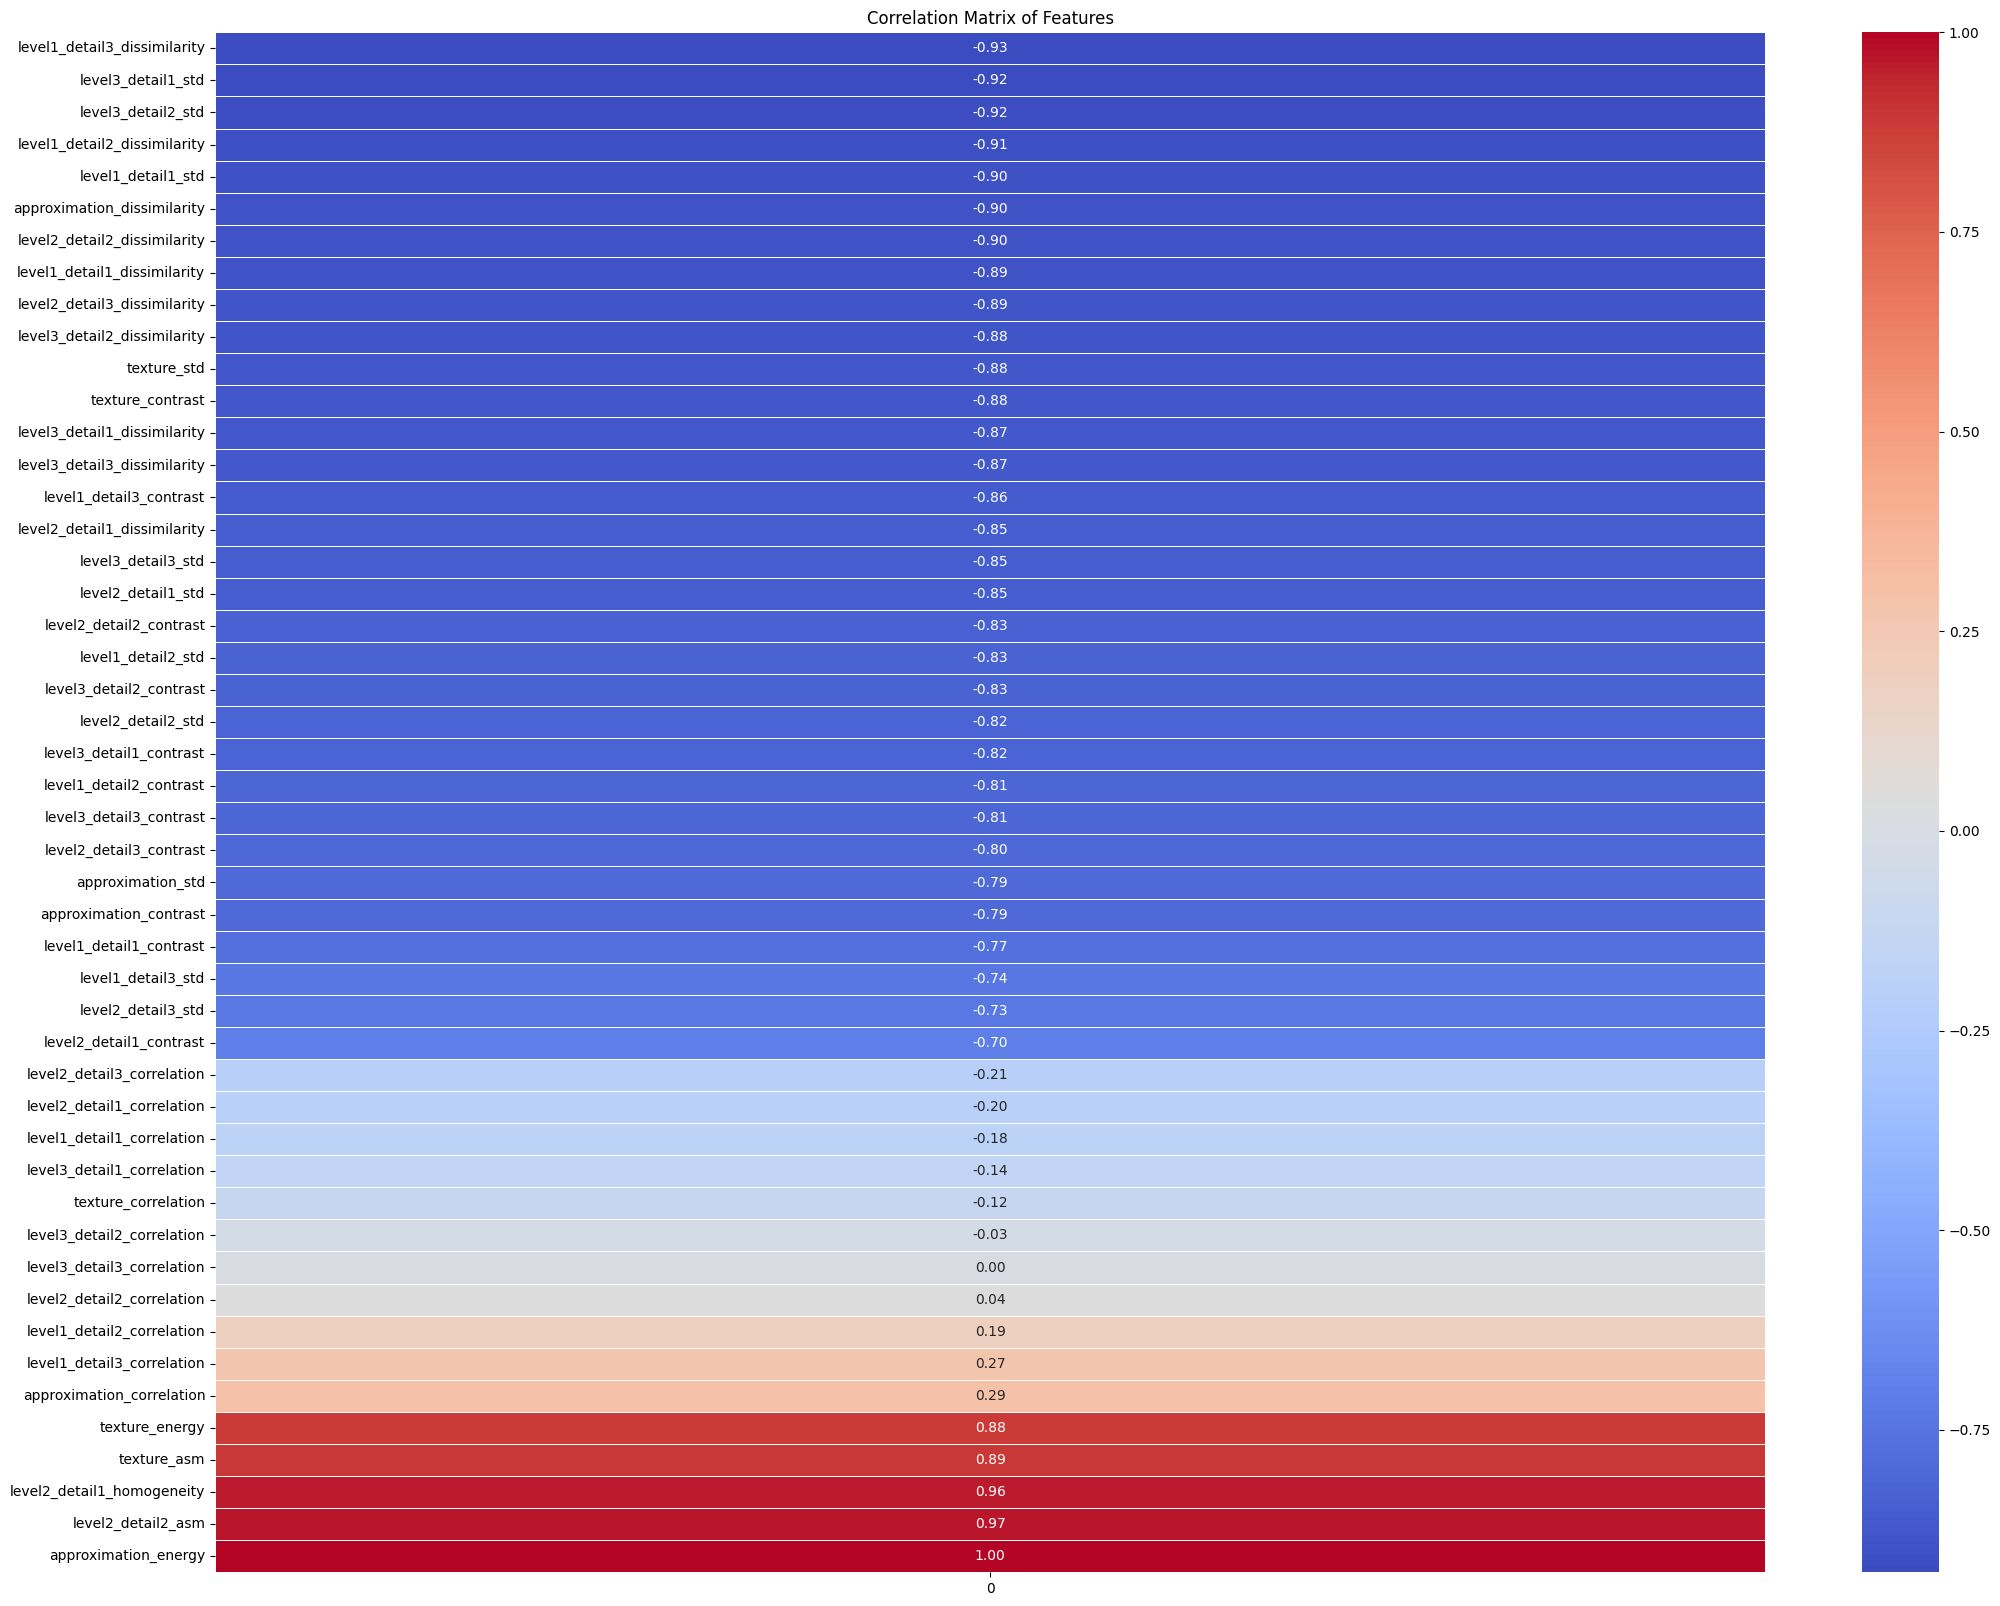

In [ ]:
plt.figure(figsize=(25, 20))
sns.heatmap(df.drop(columns=['class']).corrwith(df['approximation_energy']).sort_values().to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

## Features selection by  SBS

In [51]:
# Assuming df is your DataFrame containing features and target
X = df.drop(columns=['class'])
y = df['class']
min_list = []
max_list = []
mean_list = []
# Iterate through each feature
for feature in X.columns:
    # Temporarily remove the current feature from the dataset
    X_temp = X.drop(columns=feature)
    pca = PCA(n_components=X_temp.shape[1])
    scaler = MinMaxScaler()
    x_train,x_test,y_train,y_test = train_test_split(X_temp,y,random_state=42,train_size=.8)
    # Initialize the model pipeline
    model = make_pipeline(scaler, pca, RandomForestClassifier(random_state=42, n_estimators=835))
    # Fit the model on the modified dataset
    model.fit(x_train, y_train)
    # Calculate cross-validation accuracy
    cv_acc_scores = cross_val_score(model, X_temp, y, cv=5, n_jobs=-1)
    mean_cv_acc = np.mean(cv_acc_scores) * 100
    acc =(model.score(x_test,y_test))
    # Print the name of the removed feature and its mean cross-validation accuracy
    print(f"Removed {feature}, Mean Accuracy: {mean_cv_acc:.3f}%",cv_acc_scores*100, np.min(cv_acc_scores)*100,f"score {acc}")
    min_list.append((np.min(cv_acc_scores)*100, feature))
    max_list.append((np.max(cv_acc_scores)*100, feature))
    mean_list.append((np.mean(cv_acc_scores)*100, feature))

Removed approximation_std, Mean Accuracy: 96.400% [96.875 95.375 97.    95.875 96.875] 95.375 score 0.97
Removed approximation_correlation, Mean Accuracy: 95.725% [95.625 94.375 97.375 94.625 96.625] 94.375 score 0.94875
Removed level1_detail1_std, Mean Accuracy: 96.575% [96.375 95.875 97.    96.375 97.25 ] 95.875 score 0.96
Removed level1_detail1_correlation, Mean Accuracy: 95.875% [96.25  95.375 96.625 95.    96.125] 95.0 score 0.95625
Removed level1_detail2_std, Mean Accuracy: 96.625% [97.25  95.5   97.5   95.5   97.375] 95.5 score 0.9625
Removed level1_detail2_correlation, Mean Accuracy: 96.575% [97.125 95.625 96.875 96.375 96.875] 95.625 score 0.96375
Removed level1_detail3_std, Mean Accuracy: 96.600% [96.   96.25 97.5  95.75 97.5 ] 95.75 score 0.95875
Removed level1_detail3_correlation, Mean Accuracy: 96.475% [96.    95.625 97.5   96.5   96.75 ] 95.625 score 0.97
Removed level2_detail1_std, Mean Accuracy: 96.525% [96.625 96.    97.125 95.625 97.25 ] 95.625 score 0.965
Removed lev

95.9 array([95.875, 95.   , 96.   , 95.625, 97.   ]) acc= 95.875

In [ ]:
sorted(min_list, key=lambda x: x[0])

[(94.375, 'approximation_correlation'),
 (94.75, 'level3_detail1_correlation'),
 (94.875, 'level3_detail2_correlation'),
 (95.0, 'level1_detail1_correlation'),
 (95.0, 'level2_detail3_correlation'),
 (95.125, 'texture_contrast'),
 (95.25, 'level2_detail1_std'),
 (95.25, 'level2_detail2_correlation'),
 (95.375, 'approximation_std'),
 (95.375, 'level1_detail2_std'),
 (95.5, 'level2_detail1_correlation'),
 (95.5, 'level2_detail3_std'),
 (95.625, 'level1_detail3_std'),
 (95.625, 'level2_detail2_std'),
 (95.625, 'texture_std'),
 (95.625, 'texture_ASM'),
 (95.625, 'texture_correlation'),
 (95.75, 'level1_detail2_correlation'),
 (95.75, 'level1_detail3_correlation'),
 (95.75, 'texture_energy'),
 (95.875, 'level1_detail1_std'),
 (95.875, 'level3_detail1_std'),
 (95.875, 'level3_detail2_std'),
 (95.875, 'level3_detail3_std')]

In [ ]:
sorted(max_list, key=lambda x: x[0])

[(96.25, 'level3_detail1_correlation'),
 (96.625, 'level1_detail1_correlation'),
 (96.875, 'texture_ASM'),
 (97.0, 'approximation_std'),
 (97.0, 'level1_detail2_correlation'),
 (97.0, 'level3_detail3_std'),
 (97.125, 'level3_detail2_std'),
 (97.125, 'texture_std'),
 (97.125, 'texture_correlation'),
 (97.25, 'approximation_correlation'),
 (97.25, 'level1_detail1_std'),
 (97.25, 'level1_detail3_correlation'),
 (97.25, 'level2_detail3_std'),
 (97.25, 'level3_detail2_correlation'),
 (97.375, 'level1_detail2_std'),
 (97.375, 'texture_contrast'),
 (97.5, 'level2_detail2_correlation'),
 (97.5, 'level2_detail3_correlation'),
 (97.5, 'texture_energy'),
 (97.625, 'level1_detail3_std'),
 (97.625, 'level2_detail1_std'),
 (97.625, 'level3_detail1_std'),
 (97.75, 'level2_detail1_correlation'),
 (97.875, 'level2_detail2_std')]

In [52]:
sorted(mean_list, key=lambda x: x[0])

[(95.32499999999999, 'level3_detail1_correlation'),
 (95.725, 'approximation_correlation'),
 (95.875, 'level1_detail1_correlation'),
 (96.075, 'level3_detail2_correlation'),
 (96.22500000000001, 'texture_ASM'),
 (96.275, 'level2_detail3_correlation'),
 (96.30000000000001, 'texture_contrast'),
 (96.35000000000001, 'level3_detail2_std'),
 (96.4, 'approximation_std'),
 (96.42499999999998, 'level2_detail2_correlation'),
 (96.475, 'level1_detail3_correlation'),
 (96.52499999999999, 'level2_detail1_std'),
 (96.52499999999999, 'level3_detail3_std'),
 (96.55, 'texture_std'),
 (96.57500000000002, 'level1_detail1_std'),
 (96.57500000000002, 'level1_detail2_correlation'),
 (96.6, 'level1_detail3_std'),
 (96.6, 'level2_detail3_std'),
 (96.625, 'level1_detail2_std'),
 (96.625, 'texture_energy'),
 (96.625, 'texture_correlation'),
 (96.64999999999999, 'level2_detail1_correlation'),
 (96.7, 'level2_detail2_std'),
 (96.75, 'level3_detail1_std')]


## test rotation of the data set 

In [ ]:
image_data = np.array([item[0] for item in images])
labels = [item[1] for item in images]

rotated_images = np.rot90(image_data, k=1, axes=(1, 2))

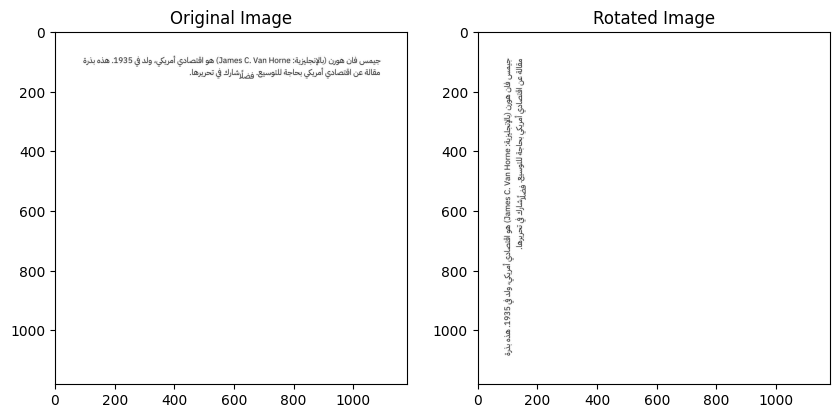

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Rotate all images by 90 degrees
# Display the first image before and after rotation
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Show the original image
axes[0].imshow(image_data[0], cmap='gray')
axes[0].set_title('Original Image')

# Show the rotated image
axes[1].imshow(rotated_images[0], cmap='gray')
axes[1].set_title('Rotated Image')

plt.show()


In [ ]:
test_df = Wrangle(list(zip(image_data, labels)))

In [ ]:
X_t = test_df.drop(columns="class")
y_t= test_df['class']

In [ ]:
model.score(X_t,y_t)*100

98.775

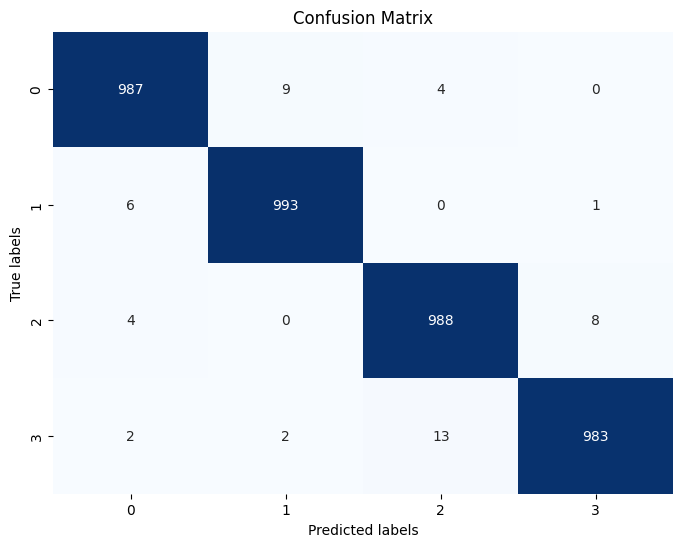

In [ ]:
conf_matrix = confusion_matrix(y_t, model.predict(X_t))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
y_pred = model.predict(X)

# Compare the predicted labels with the true labels to find misclassifications
misclassified_indices = np.where(y_pred != y)[0]

In [ ]:
misclassified_indices

array([  61,   88,  257,  351,  354,  387,  408,  429,  495,  534,  655,
        680,  862, 1104, 1171, 1315, 1345, 1498, 1539, 1745, 2024, 2216,
       2282, 2334, 2345, 2378, 2428, 2585, 2618, 2643, 2736, 2771, 3055,
       3123, 3148, 3200, 3201, 3249, 3322, 3353, 3414, 3456, 3570, 3614,
       3693, 3749, 3925, 3991, 3992], dtype=int64)

In [ ]:
y_test[misclassified_indices]

In [ ]:
y_pred[misclassified_indices]

## PREV tests and features

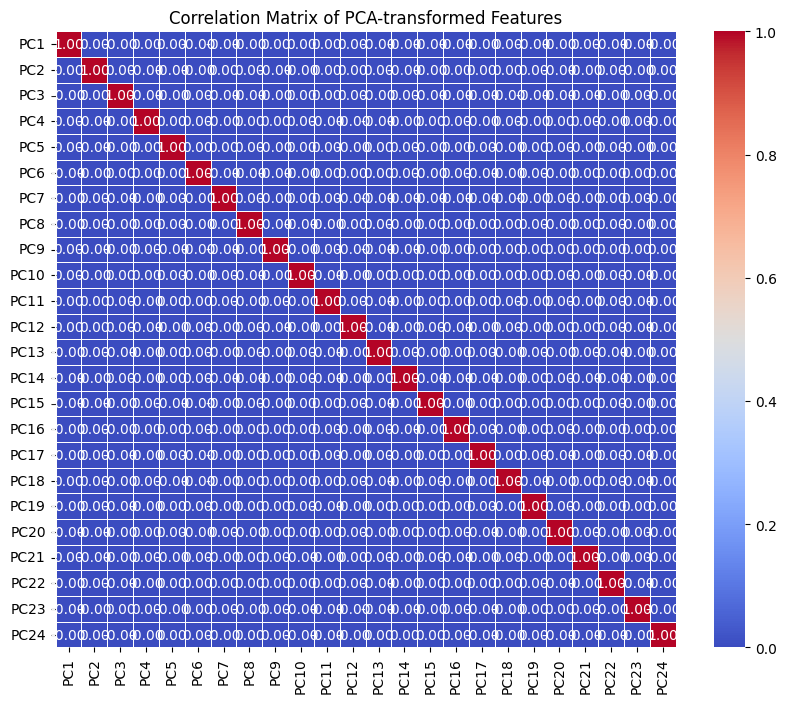

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Assuming df is your DataFrame containing the features

# Drop the 'class' column before applying PCA
features = df.drop(columns=['class'])

# Standardize the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA()
pca.fit(features_scaled)
features_pca = pca.transform(features_scaled)

# Convert the PCA results back to a DataFrame
df_pca = pd.DataFrame(features_pca, columns=[f'PC{i+1}' for i in range(features_pca.shape[1])])

# Calculate the correlation matrix for the PCA-transformed features
correlation_matrix_pca = df_pca.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_pca, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of PCA-transformed Features')
plt.show()


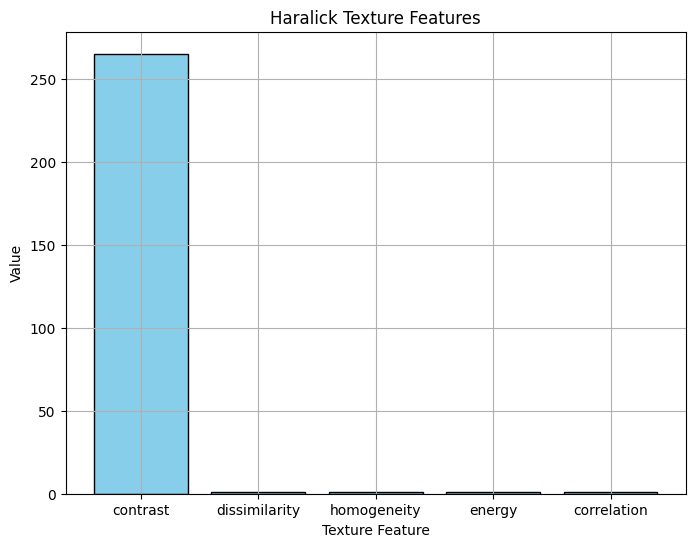

In [ ]:
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
import numpy as np

def plot_texture_features(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True):
    # Compute GLCM
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=symmetric, normed=normed)
    
    # Calculate Haralick Texture Features
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    texture_features = [graycoprops(glcm, prop).ravel()[0] for prop in properties]
    
    # Plot the texture features
    plt.figure(figsize=(8, 6))
    plt.bar(properties, texture_features, color='skyblue', edgecolor='black')
    plt.xlabel('Texture Feature')
    plt.ylabel('Value')
    plt.title('Haralick Texture Features')
    plt.grid(True)
    plt.show()

img = cv2.imread('./image.jpg', cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
img = color_treatment(img)
# Call the function to plot texture features for an image
plot_texture_features(img)


c:\Users\20112\AppData\Local\Programs\Python\Python38\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


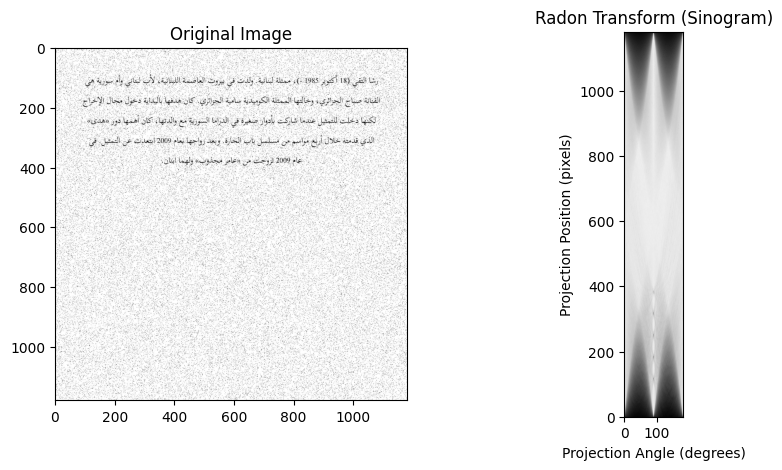

In [ ]:
from skimage.transform import radon

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta)

# Plot the original image and its sinogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.set_title('Original Image')
ax1.imshow(image, cmap='gray')

ax2.set_title('Radon Transform (Sinogram)')
ax2.set_xlabel('Projection Angle (degrees)')
ax2.set_ylabel('Projection Position (pixels)')
ax2.imshow(sinogram, cmap='gray', extent=(0, 180, 0, sinogram.shape[0]))

plt.show()